<a href="https://colab.research.google.com/github/halizz821/DeepLearning_HSI_Classification/blob/main/1D_CNN/HyperspectralClassification1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mountin Google Drive

In [ ]:
####### Mounting your google drive
from google.colab import drive
drive.mount('/content/drive')

####### Data address in google drive
%cd /content/drive/MyDrive/Colab Notebooks/DeepLearning-HSI classification

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [ ]:
!pip install earthpy

import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

seed(11)

# Load Data

In [ ]:
################## Load Hyperspectral image
data = loadmat('Pavia.mat')['pavia']


###################### Load Ground Truth image
gt = loadmat('Pavia_gt.mat')['pavia_gt']

print(f'Image Shape: {data.shape[:-1]}\nNumber of Spectral bands: {data.shape[-1]}')

Data Shape: (1096, 715)
Number of Bands: 102


# Data Visualization

*This section of code is not necessary and you can skip it. It just visuallizes some spectral bands of the input image to get familiar with your data*

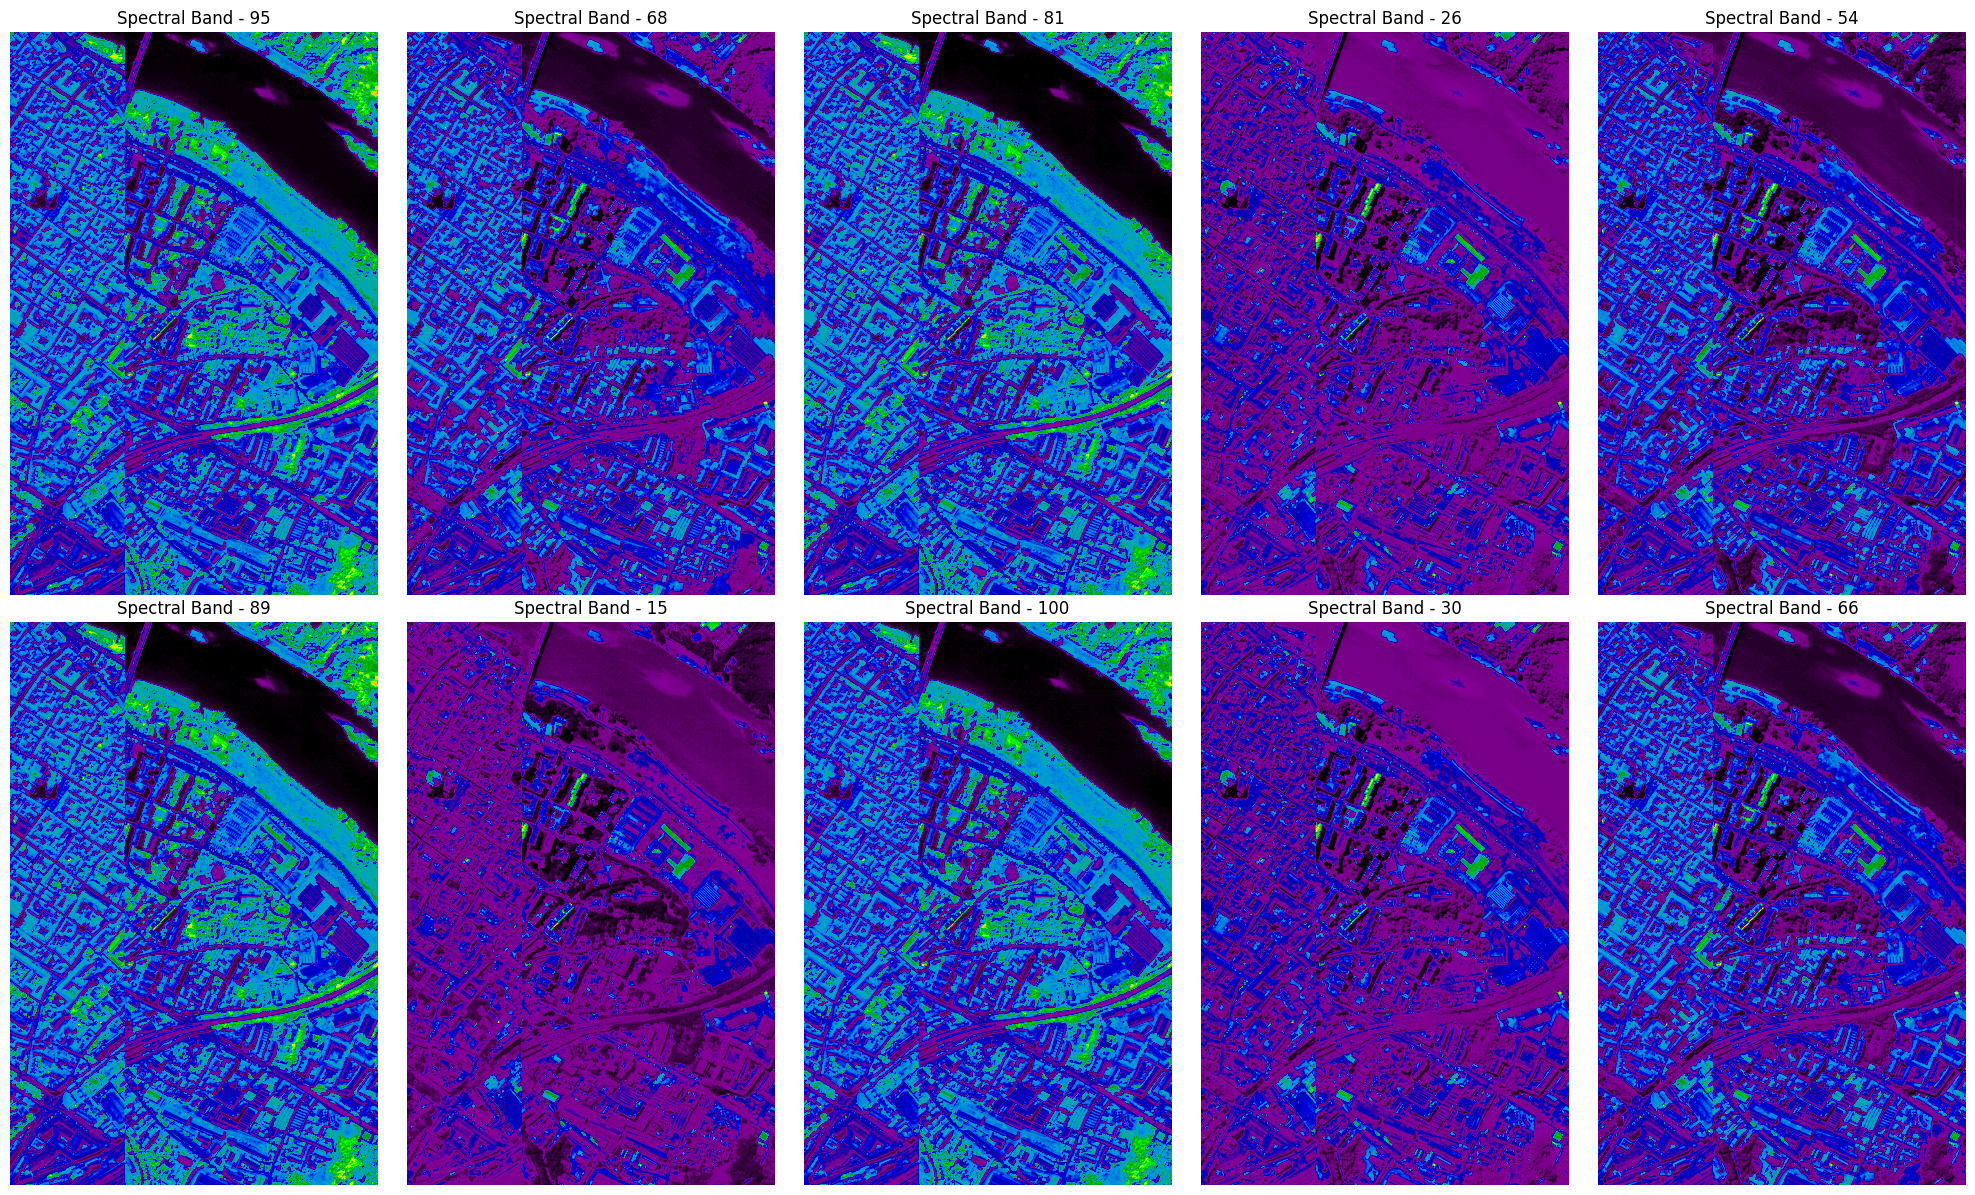

In [ ]:
fig = plt.figure(figsize = (20, 12))  # open a figure

ax = fig.subplots(2, 5) # divide the figure into several subfigures

##### plot each subplot
for i in range(2):
  for j in range(5):
    c = np.random.randint(data.shape[2]) ### randomely select a spectral band
    ax[i][j].imshow(data[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Spectral Band - {c}") # title
    c+=1

plt.tight_layout()
plt.show()


# RGB Composite Visualization

*This section of code is not necessary and you can skip it. It just visuallizes an RGB color composite of the input image to get familiar with your data*

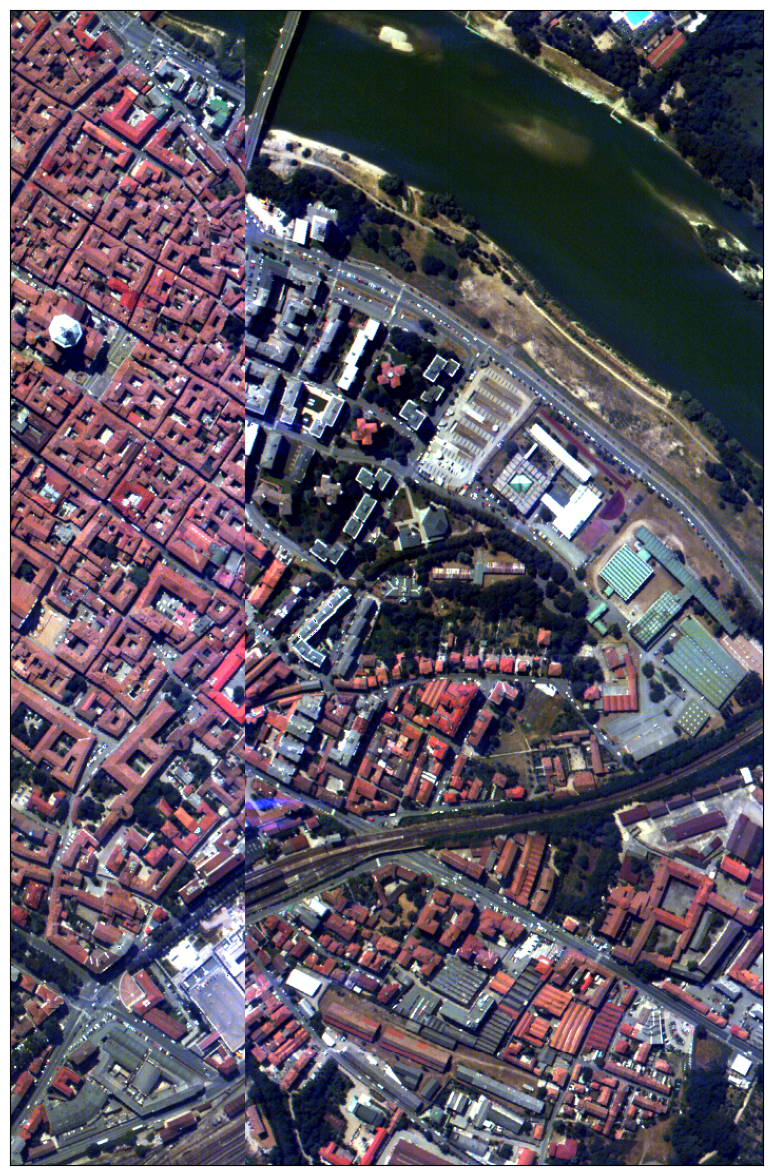

In [ ]:
mdata = np.moveaxis(data, -1, 0) # becauase mdata in ep.plot_rgb shoould be An n-dimensional array in rasterio band order (bands, rows, columns) containing the layers to plot.
R=50 # Red spectral band number
G=23 # Green spectral band number
B=2  # Blue spectral band number
ep.plot_rgb(mdata, (R,G,B), figsize=(15, 15),stretch=True)  # Plot red, green, and blue bands, respectively

plt.show()

# GroundTruth Visualizaation

*This section of code is not necessary and you can skip it. It just visuallizes your ground truth to get more familiar with your data*

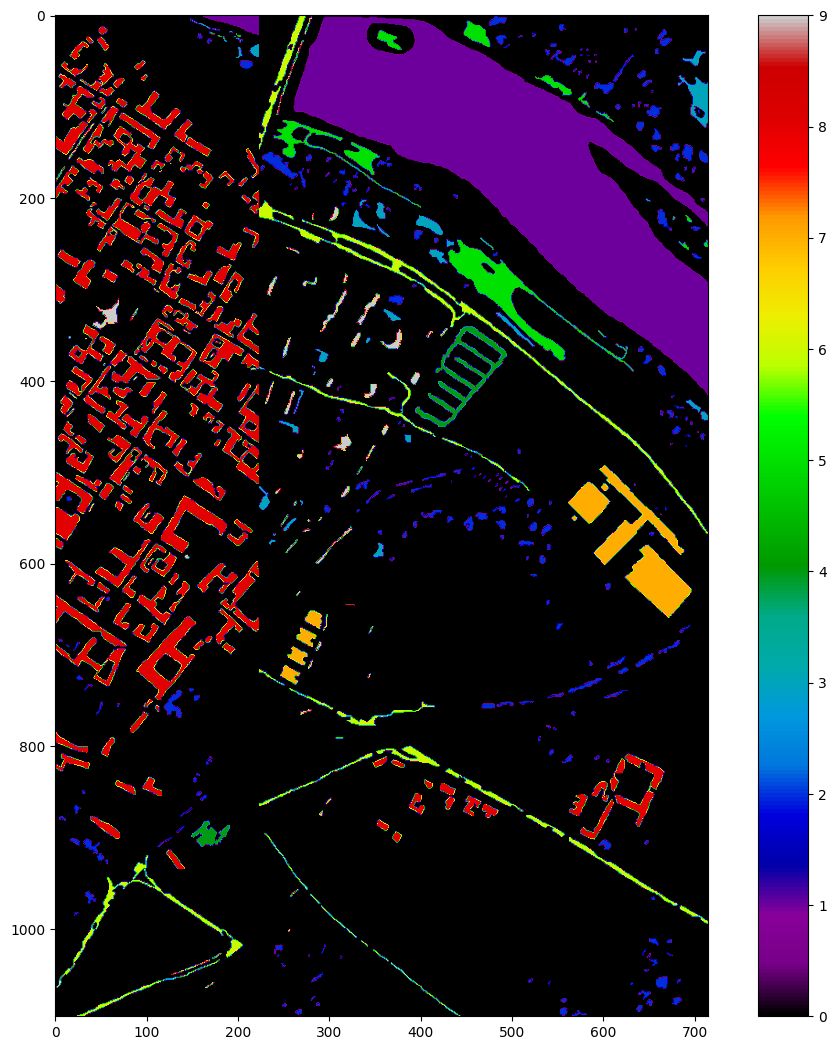

In [ ]:
def plot_data(data):
  fig = plt.figure(figsize=(13, 13)) # open a figure
  plt.imshow(data, cmap='nipy_spectral') #plot the groud truth
  plt.colorbar() # add colorbar
  plt.axis('on') # Trun the axis on
  plt.show()

plot_data(gt)

# Pre-processing
This step includes:

  1) Finding the ground truth samples in the image

  2) Encode labels of each class

  3) Split samples into training, validation and test samples

  4) Scaling samples to [0,1] interval

In [ ]:
################# Finding the ground truth samples in the image

a=np.where(gt!=0) # find the labled data in ground truth gt
samples=data[a[0],a[1],:] #samples with label
labels= gt[a[0],a[1]] #label of the samples

################# Encode labels of each class

enc = OneHotEncoder()
y=enc.fit_transform(labels.reshape(-1, 1)).toarray() #turn labels to categorical (i.e., each label is represented by a vector) usig  OneHotEncoder method

################# Split samples into: 1) Training, 2) Validation and 3) Test samples

X_train, X_test, y_train, y_test = train_test_split(samples, y,
                                                    stratify=y,
                                                    train_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    stratify=y_train,
                                                    train_size=0.7)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_validation: {X_val.shape}\ny_validation: {y_val.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

################ Scaling

# Find the minimum and maximum values of the array
min_value = np.min(X_train)
max_value = np.max(X_train)

# Scale the array between 0 and 1
X_train_scaled = (X_train - min_value) / (max_value - min_value)
X_val_scaled = (X_val - min_value) / (max_value - min_value)
X_test_scaled = (X_test - min_value) / (max_value - min_value)



X_train: (20741, 102)
y_train: (20741, 9)
X_validation: (8889, 102)
y_validation: (8889, 9)
X_test: (118522, 102)
y_test: (118522, 9)


# Build CNN

In [ ]:
ip_shape = X_train.shape[1] # input shape of model
n_outputs = y_train.shape[1] # output shape of model

In [ ]:
model = Sequential(name = '1D_CNN')

model.add(Conv1D(filters = 32, kernel_size = 1, activation ='relu', input_shape =(ip_shape,1,), name = 'Layer1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer2'))
model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
model.add(Dropout(0.4, name = 'Dropout1'))

model.add(Conv1D(filters = 64, kernel_size = 1, activation ='relu', name = 'Layer3'))
model.add(Conv1D(filters = 128, kernel_size = 3, activation ='relu' , name = 'Layer4'))
model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
model.add(Dropout(0.4, name = 'Dropout2'))

model.add(Flatten(name = 'Flatten'))

model.add(Dense(200, activation='relu', name = 'DenseLayer1'))
model.add(Dense(50, activation='relu', name = 'DenseLayer2'))

model.add(Dense(n_outputs, activation='softmax', name = 'OutputLayer'))

model.summary()

Model: "1D_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv1D)             (None, 102, 32)           64        
                                                                 
 Layer2 (Conv1D)             (None, 100, 64)           6208      
                                                                 
 MaxPooling_Layer1 (MaxPooli  (None, 50, 64)           0         
 ng1D)                                                           
                                                                 
 Dropout1 (Dropout)          (None, 50, 64)            0         
                                                                 
 Layer3 (Conv1D)             (None, 50, 64)            4160      
                                                                 
 Layer4 (Conv1D)             (None, 48, 128)           24704     
                                                            

# Train CNN model

In [ ]:
######## compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

######## define calback of the model
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Pavia_Model.h5',
                             monitor = 'val_loss',
                             mode ='min',
                             save_best_only = True) # save the model with the best loss performance on validation data

tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

########## Fit the model on training samples
hist = model.fit(X_train_scaled,
                       y_train,
                       epochs = 5, #No of epochs
                       batch_size = 32, # batch size
                       validation_data = (X_val_scaled, y_val), # validation data
                       callbacks=[early_stop,
                                  checkpoint,
                                  tensorboard])


Epoch 1/5
649/649 [==============================] - 15s 17ms/step - loss: 0.2762 - accuracy: 0.9103 - val_loss: 0.1263 - val_accuracy: 0.9477
Epoch 2/5
649/649 [==============================] - 11s 16ms/step - loss: 0.1266 - accuracy: 0.9507 - val_loss: 0.1249 - val_accuracy: 0.9542
Epoch 3/5
649/649 [==============================] - 13s 21ms/step - loss: 0.1122 - accuracy: 0.9575 - val_loss: 0.1343 - val_accuracy: 0.9556
Epoch 4/5
649/649 [==============================] - 9s 13ms/step - loss: 0.1019 - accuracy: 0.9592 - val_loss: 0.1072 - val_accuracy: 0.9566
Epoch 5/5
649/649 [==============================] - 7s 11ms/step - loss: 0.0988 - accuracy: 0.9628 - val_loss: 0.1146 - val_accuracy: 0.9583


# Plot results (loss and accuracy) of all epochs

In [ ]:
# %load_ext tensorboard

# %tensorboard --logdir SA_logs/

In [ ]:
hist2 = pd.DataFrame(data= hist.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist2.index, y = hist2.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist2.index, y = hist2.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist2.index, y = hist2.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist2.index, y = hist2.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

# Validate the performance of the model

3704/3704 [==============================] - 14s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52755
           1       0.99      0.78      0.87      7655
           2       0.29      0.90      0.44       793
           3       0.14      0.70      0.23       424
           4       1.00      0.74      0.85      7061
           5       0.97      0.89      0.93      7993
           6       0.89      0.91      0.90      5701
           7       0.99      1.00      0.99     33841
           8       1.00      0.99      0.99      2299

    accuracy                           0.96    118522
   macro avg       0.81      0.88      0.80    118522
weighted avg       0.98      0.96      0.96    118522

Overall Accuracy: 95.675064544979
Kappa coefficient: 0.9387529341057754
Producer accuracy: [99.94315706 98.66732478 28.88349515 13.73370577 99.58230492 96.55358832
 88.93653516 98.61358396 99.69432314] 


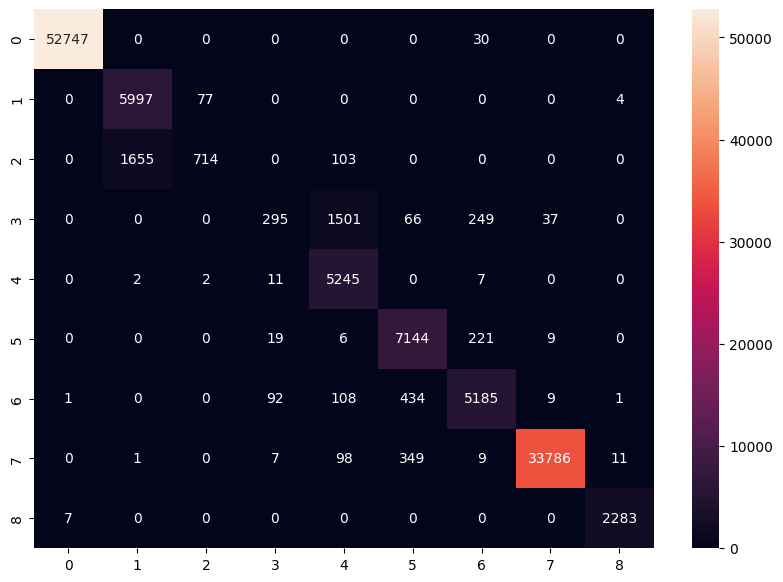

In [ ]:
######## load the model with the best performance on validation samples
from tensorflow.keras.models import load_model

model = load_model("Pavia_Model.h5") # loading the model with the best validation metric

########## Results on test samples

pred = np.argmax(model.predict(X_test_scaled), axis=1) # predic for the the test samples

# Classification Report
print(classification_report(pred, np.argmax(y_test, 1)))

from sklearn.metrics import *
Kappa=cohen_kappa_score(np.argmax(y_test, 1),pred) # calculate Kappa coefficient
OA=accuracy_score(np.argmax(y_test, 1),pred) # calculate Overall accuracy
matrix = confusion_matrix(np.argmax(y_test, 1),pred) # calculate confusion matrix
Producer_accuracy= matrix.diagonal()/matrix.sum(axis=1) # calculate producer accuracy

print(f"Overall Accuracy: {OA*100}\nKappa coefficient: {Kappa}\nProducer accuracy: {Producer_accuracy*100} ")

# plot confusion matrix in a heatmap
plt.figure(figsize = (8,5))
df_cm = pd.DataFrame(matrix)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()


# Predicting whole image

24489/24489 [==============================] - 106s 4ms/step


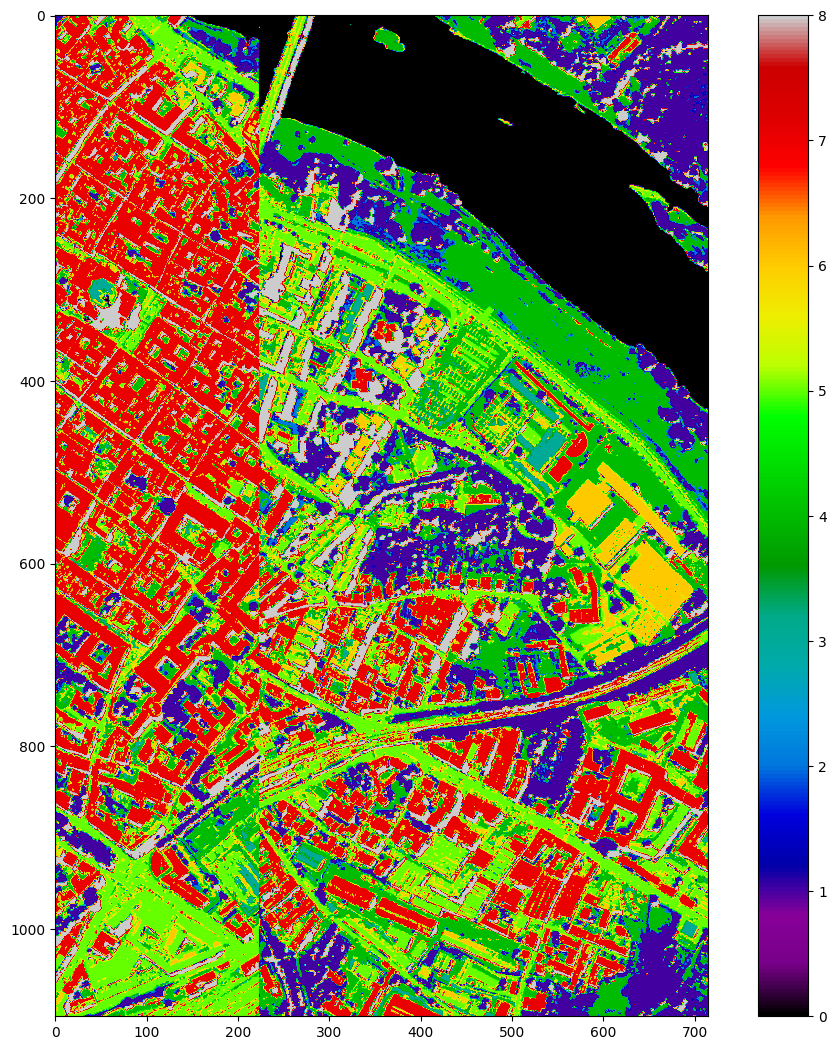

In [ ]:
image = data.reshape(data.shape[0]*data.shape[1], -1) # reshape the image
image_scaled = (image - min_value) / (max_value - min_value) # scale the image pixels

prediction = np.argmax(model.predict(image_scaled), axis=1) # predict each pixel's class

prediction_reshaped = prediction.reshape(data.shape[0],data.shape[1]) # reshape the prediced values to form an image

######## Plot the classified image
def plot_data(data):
  fig = plt.figure(figsize=(13, 13)) # open a figure
  plt.imshow(data, cmap='nipy_spectral') #plot the groud truth
  plt.colorbar() # add colorbar
  plt.axis('on') # Trun the axis on
  plt.show()

plot_data(prediction_reshaped)
